In [4]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# unconstrained_min.py

In [897]:
def get_gradient(f,x):
    '''     
    eps=1e-12
    grad = np.zeros_like(x)

    for i in range(len(x)):
        x_eps = x.copy()
        x_eps[i] += eps
        grad[i] = (f(x_eps) - f(x)) / eps
        return grad
    ''' 
    return optimize.approx_fprime(x, f, epsilon=1e-12)

In [898]:
def wolfe_condition(f, grad, x, alpha=1.0, c1=0.5, beta=0.8):
    while f(x + alpha*grad) > f(x)+c1*alpha*np.dot((-grad).T, grad):
        alpha *= beta
    return alpha

In [899]:
def gradient_descent(f,x,obj_tol=1e-12, param_tol=1e-8, max_iter=100):
    path=[]
    #record start point of path
    path.append(x)
    flag = False
    for i in range(max_iter):
        grad = -get_gradient(f,x)
        
#        if (np.isclose(np.linalg.norm(grad),np.zeros_like(x)).all()):
#            flag = True
#            return x,f(x),flag, path
        
        step = wolfe_condition(f,grad,x)
        new_x = x + step*grad
        
        if (np.linalg.norm(step*grad) < param_tol) or (np.abs(f(new_x)-f(x)) < obj_tol):
            flag = True
            return x,f(x),flag, path
        
        path.append(new_x)
        #print('the iteration is', i+1, 'the current location is', new_x, 'and the current objective value is', f(new_x))
        x = new_x
    return x,f(x),flag, path

In [925]:
def get_hessian(f, x):
    n = len(x)
    hessian = np.zeros((n, n))
    eps = 1e-6

    for i in range(n):
        for j in range(n):
            f_xx = (f(x + eps*np.eye(n)[i] + eps*np.eye(n)[j]) - f(x + eps*np.eye(n)[i]) -
                    f(x + eps*np.eye(n)[j]) + f(x)) / (eps**2)
            hessian[i, j] = f_xx

    return hessian

In [999]:
def newton(f,x, obj_tol=1e-12, param_tol=1e-8, max_iter=100):
    path=[]
    #record start point of path
    path.append(x)
    flag = False
    for i in range(max_iter):
        grad = -get_gradient(f,x)
        hessian = get_hessian(f, x)
        if np.linalg.det(hessian) == 0:
            return x,f(x),flag, path
        
        direction = np.linalg.solve(hessian, grad)
        step = wolfe_condition(f,direction,x)
        new_x = x + step*direction

        if (np.linalg.norm(step*direction) < param_tol) or (np.abs(f(new_x)-f(x)) < obj_tol):
            flag = True
            return x,f(x),flag, path

        path.append(new_x)
        #print('the iteration is', i+1, 'the current location is', new_x, 'and the current objective value is', f(new_x))
        x = new_x
    return x,f(x),flag, path

In [984]:
def BFGS(f,x, obj_tol=1e-12, param_tol=1e-8, max_iter=100):
    path=[]
    #record start point of path
    path.append(x)
    flag = False
    #initial B
    B=np.eye(len(x))
    for i in range(max_iter):
        grad = get_gradient(f,x)

        #B_kd=-gk
        direction = -np.linalg.solve(B, grad)
        step = wolfe_condition(f,direction,x)
        p = step*direction
        new_x = x + p

        if (np.linalg.norm(step*direction) < param_tol) or (np.abs(f(new_x)-f(x)) < obj_tol):
            flag = True
            return x,f(x),flag, path

        path.append(new_x)
        #print('the iteration is', i+1, 'the current location is', new_x, 'and the current objective value is', f(new_x))

        #update B
        q = get_gradient(f,new_x)-get_gradient(f,x)
        dB = (np.outer(q, q) / np.dot(q, p)) - (np.outer(B @ p, B @ p) / np.dot(p, B @ p))

        #dB = np.dot(q,q.T)/np.dot(q.T,p)-np.dot(np.dot(np.dot(B,p),p.T),B)/np.dot(np.dot(p.T,B),p)
        B = B + dB
        x = new_x

    return x,f(x),flag, path

In [992]:
def SR1(f,x, obj_tol=1e-12, param_tol=1e-8, max_iter=100):
    path=[]
    #record start point of path
    path.append(x)
    flag = False
    #initial B
    B=np.eye(len(x))
    for i in range(max_iter):
        grad = get_gradient(f,x)

        direction = -np.dot(B,grad)
        step = wolfe_condition(f,direction,x)
        p = step*direction
        new_x = x + p
        if (np.linalg.norm(p) < param_tol) or (np.abs(f(new_x)-f(x)) < obj_tol):
            flag = True
            return x,f(x),flag, path

        path.append(new_x)
        #print('the iteration is', i+1, 'the current location is', new_x, 'and the current objective value is', f(new_x))

        #update B
        q = get_gradient(f,new_x)-get_gradient(f,x)

        dB = np.outer(p - np.dot(B, q), p - np.dot(B, q)) / np.dot(p - np.dot(B, q), q)
        #dB = np.dot((p-np.dot(B,q)),(p-np.dot(B,q)).T)/np.dot((p-np.dot(B,q)).T,q)
        B = B + dB
        x = new_x

    return x,f(x),flag, path

# examples.py

In [2]:
from unconstrained_min import get_gradient
from unconstrained_min import get_hessian

## q1

In [6]:
def f1(x):
    q=np.array([[1,0],[0,1]])
    x = np.array(x)
    return np.dot(np.dot((x.T),q),x)

In [ ]:
def q1(x, y):
    return x ** 2 + y** 2

In [ ]:
def function1(x,bool_v=False):
    f=f1(x)
    g=get_gradient(f1,x)
    if bool_v==True:
        return f,g,get_hessian(f1,x)
    return f,g

## q2

In [906]:
def f2(x):
    q=np.array([[1,0],[0,100]])
    x = np.array(x)
    return np.dot(np.dot((x.T),q),x)

In [907]:
def q2(x, y):
    return x ** 2 + 100*y** 2

In [ ]:
def function2(x,bool_v=False):
    f=f2(x)
    g=get_gradient(f2,x)
    if bool_v==True:
        return f,g,get_hessian(f2,x)
    return f,g

## q3

In [908]:
def f3(x):
    a=np.array([[np.sqrt(3)/2,-0.5],[0.5,np.sqrt(3)/2]]).T
    b=np.array([[100,0],[0,1]])
    c=np.array([[np.sqrt(3)/2,-0.5],[0.5,np.sqrt(3)/2]])
    q=np.dot(np.dot(a,b),c)
    x = np.array(x)
    return np.dot(np.dot((x.T),q),x)

In [ ]:
def function3(x,bool_v=False):
    f=f3(x)
    g=get_gradient(f3,x)
    if bool_v==True:
        return f,g,get_hessian(f3,x)
    return f,g

##  Rosenbrock function

In [909]:
def fRosenbrock(x):
    x = np.array(x)
    q=np.array([[1200*x[0]**2-400*x[1],-400*x[0]],[-400*x[0],200]])
    return np.dot(np.dot((x.T),q),x)

In [910]:
def qRosenbrock(x1,x2):
    return 100*(x2-x1**2)**2+(1-x1)

In [ ]:
def function4(x,bool_v=False):
    f=fRosenbrock(x)
    g=get_gradient(fRosenbrock,x)
    if bool_v==True:
        return f,g,get_hessian(fRosenbrock,x)
    return f,g

##  A linear function

In [911]:
def f5(x):
    a=np.array([3,5])
    x = np.array(x)
    return np.dot((a.T),x)

In [ ]:
def function5(x,bool_v=False):
    f=f5(x)
    g=get_gradient(f5,x)
    if bool_v==True:
        return f,g,get_hessian(f5,x)
    return f,g

##  smoothed corner triangles

In [1008]:
def q6(x1,x2):
    return np.e**(x1+3*x2-0.1)+np.e**(x1-3*x2-0.1)+np.e**(-x1-0.1)

In [1023]:
def f6(x):
    return q6(x[0],x[1])

In [ ]:
def function6(x,bool_v=False):
    f=f6(x)
    g=get_gradient(f6,x)
    if bool_v==True:
        return f,g,get_hessian(f6,x)
    return f,g

# utils.py

In [1]:
import numpy as np
from scipy import optimize
from unconstrained_min import *
import matplotlib.pyplot as plt
from examples import f1,f2,f3,fRosenbrock,f5,f6

In [2]:
def plot_all(f,x,a,b,l, obj_tol=1e-12, param_tol=1e-8, max_iter=100):
    paths={}
    flag = {}
    x1,y1,flag["gradient_descent"], paths["gradient_descent"] = gradient_descent(f,x,obj_tol,param_tol,max_iter)
    
    x2,y2,flag["newton"], paths["newton"] = newton(f,x,obj_tol,param_tol,max_iter)
    
    x3,y3,flag["BFGS"], paths["BFGS"] = BFGS(f,x,obj_tol,param_tol,max_iter)
  
    x4,y4,flag["SR1"], paths["SR1"] = SR1(f,x,obj_tol,param_tol,max_iter)

    
    # Define the contour grid
    x1 = np.linspace(-a, a, 100)
    x2 = np.linspace(-b, b, 100)
    X1, X2 = np.meshgrid(x1, x2)

    Z = np.zeros_like(X1)
    for i in range(len(x1)):
        for j in range(len(x2)):
            Z[i, j] = f([X1[i, j], X2[i, j]])

    fig, axes = plt.subplots(4, 1, figsize=(10, 20))
    for i, method in enumerate(paths):
        ax = axes[i]

        # Plot the contour lines
        ax.contour(X1, X2, Z, levels=l)

        # Plot the iteration paths
        path = paths[method]
        x_vals, y_vals = zip(*path)
        ax.plot(x_vals, y_vals, marker='o', linestyle='-', color='red')
        ax.plot(x_vals[-1], y_vals[-1], marker='o', linestyle='-', color='black')
        ax.annotate(f'({x_vals[-1]}, {y_vals[-1]})', xy=(x_vals[-1], y_vals[-1]), xytext=(x_vals[-1] + 0.1, y_vals[-1] - 0.5))

        ax.set_xlabel('x')
        ax.set_ylabel('y')

        ax.set_title(method+', iteration times:'+str(len(path)-1)+', Flag:'+str(flag[method]))
        ax.grid(True)

    plt.show()

In [3]:
x =np.array([1,1]).T

In [4]:
x4 =np.array([-1,2]).T

In [5]:
plot_all(f1,x,3,3,30)

For gradient descent, the iteration is 1 the current location is [0.1808 0.1808] and the current objective value is 0.06537727999999982
For gradient descent, the iteration is 2 the current location is [0.03268962 0.03268962] and the current objective value is 0.0021372228055311247
For gradient descent, the iteration is 3 the current location is [0.0059103 0.0059103] and the current objective value is 6.986323080749835e-05
For gradient descent, the iteration is 4 the current location is [0.00106858 0.00106858] and the current objective value is 2.283717953497511e-06
For gradient descent, the iteration is 5 the current location is [0.0001932 0.0001932] and the current objective value is 7.46516324300425e-08
For gradient descent, the iteration is 6 the current location is [3.493036e-05 3.493036e-05] and the current objective value is 2.440260103178755e-09
For gradient descent, the iteration is 7 the current location is [6.31540858e-06 6.31540858e-06] and the current objective value is 7.9

In [6]:
plot_all(f2,x,1.5,1.5,30)

For gradient descent, the iteration is 1 the current location is [0.99053849 0.0554596 ] and the current objective value is 1.2887432318335759
For gradient descent, the iteration is 2 the current location is [0.98118289 0.00308002] and the current objective value is 0.9636685115964683
For gradient descent, the iteration is 3 the current location is [ 0.89487727 -0.02400983] and the current objective value is 0.8584525137858626
For gradient descent, the iteration is 4 the current location is [ 0.88642556 -0.00133329] and the current objective value is 0.7859280400900835
For gradient descent, the iteration is 5 the current location is [0.64847855 0.03445929] and the current objective value is 0.5392687351862757
For gradient descent, the iteration is 6 the current location is [0.64235369 0.00191355] and the current objective value is 0.4129844253933044
For gradient descent, the iteration is 7 the current location is [ 0.57172529 -0.01912832] and the current objective value is 0.3634590714

For gradient descent, the iteration is 76 the current location is [ 7.59584353e-04 -1.40933936e-06] and the current objective value is 5.771670130428406e-07
For gradient descent, the iteration is 77 the current location is [5.96464852e-04 2.88559840e-05] and the current objective value is 4.3903710097002717e-07
For gradient descent, the iteration is 78 the current location is [5.90831400e-04 1.60227702e-06] and the current objective value is 3.4933847277558857e-07
For gradient descent, the iteration is 79 the current location is [ 5.25868801e-04 -1.60149526e-05] and the current objective value is 3.0218586672182117e-07
For gradient descent, the iteration is 80 the current location is [ 5.20902111e-04 -8.89257824e-07] and the current objective value is 2.714180868808595e-07
For gradient descent, the iteration is 81 the current location is [4.09039236e-04 1.82073967e-05] and the current objective value is 2.004640259915139e-07
For gradient descent, the iteration is 82 the current locatio

For gradient descent, the iteration is 1 the current location is [0.69414499 1.16168443] and the current objective value is 1.8721649064283221
For gradient descent, the iteration is 2 the current location is [0.66542779 1.15983517] and the current objective value is 1.7893236359839264
For gradient descent, the iteration is 3 the current location is [0.62663299 1.0127169 ] and the current objective value is 1.5488712614358207
For gradient descent, the iteration is 4 the current location is [0.59128471 1.02013073] and the current objective value is 1.3906811782620854
For gradient descent, the iteration is 5 the current location is [0.4275352  0.82228474] and the current objective value is 1.0244335340377455
For gradient descent, the iteration is 6 the current location is [0.45660657 0.79540075] and the current objective value is 0.8416609179045141
For gradient descent, the iteration is 7 the current location is [0.42060266 0.67080235] and the current objective value is 0.7092903835989232

For gradient descent, the iteration is 61 the current location is [0.00189857 0.00372885] and the current objective value is 2.2309955684591454e-05
For gradient descent, the iteration is 62 the current location is [0.00205896 0.00359068] and the current objective value is 1.7147101758638703e-05
For gradient descent, the iteration is 63 the current location is [0.00194785 0.00312933] and the current objective value is 1.5065704203365212e-05
For gradient descent, the iteration is 64 the current location is [0.00183048 0.00315691] and the current objective value is 1.3321304764388419e-05
For gradient descent, the iteration is 65 the current location is [0.00131244 0.00255111] and the current objective value is 1.0142112426525921e-05
For gradient descent, the iteration is 66 the current location is [0.00141256 0.00246206] and the current objective value is 8.062936480300187e-06
For gradient descent, the iteration is 67 the current location is [0.00132998 0.00214936] and the current objecti

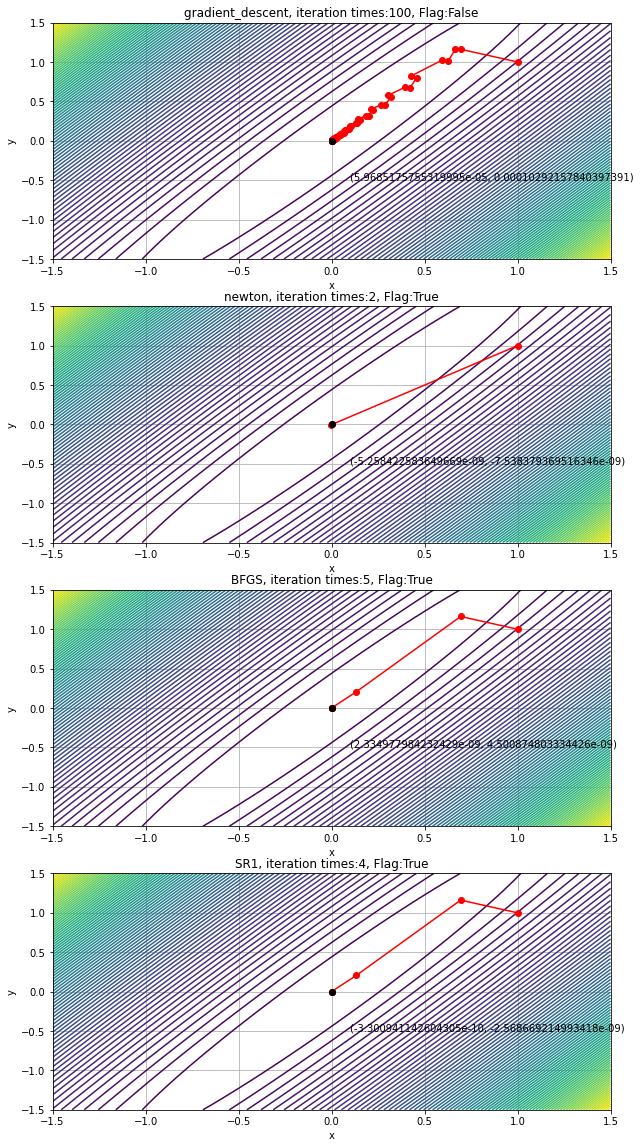

In [7]:
plot_all(f3,x,1.5,1.5,100)

For gradient descent, the iteration is 1 the current location is [-1.00027488  2.96720937] and the current objective value is -600.4227686955071
For gradient descent, the iteration is 2 the current location is [-1.1975347   2.96839885] and the current objective value is -878.1259482378568
For gradient descent, the iteration is 3 the current location is [-1.38018446  3.30653507] and the current objective value is -1017.3292196144612
For gradient descent, the iteration is 4 the current location is [-1.28936487  3.35898193] and the current objective value is -1127.9279698633707
For gradient descent, the iteration is 5 the current location is [-3.66483369 18.03159753] and the current objective value is -9120.984938652633
For gradient descent, the iteration is 6 the current location is [-3.09711772 18.09670665] and the current objective value is -32394.23679850805
For gradient descent, the iteration is 7 the current location is [-3.00486919 18.14547191] and the current objective value is -3

For gradient descent, the iteration is 57 the current location is [ -35.78566653 2557.45094312] and the current objective value is -654051253.1201869
For gradient descent, the iteration is 58 the current location is [ -35.76000339 2557.48486658] and the current objective value is -654072882.7757837
For gradient descent, the iteration is 59 the current location is [  39.65718786 2889.79186553] and the current objective value is -815491332.4972432
For gradient descent, the iteration is 60 the current location is [  38.30987299 2889.83426986] and the current objective value is -834494269.0504658
For gradient descent, the iteration is 61 the current location is [  38.03720212 2889.8696068 ] and the current objective value is -835130330.011052
For gradient descent, the iteration is 62 the current location is [  37.99710347 2889.91377798] and the current objective value is -835158501.9713284
For gradient descent, the iteration is 63 the current location is [  38.05584173 2889.97848185] and t

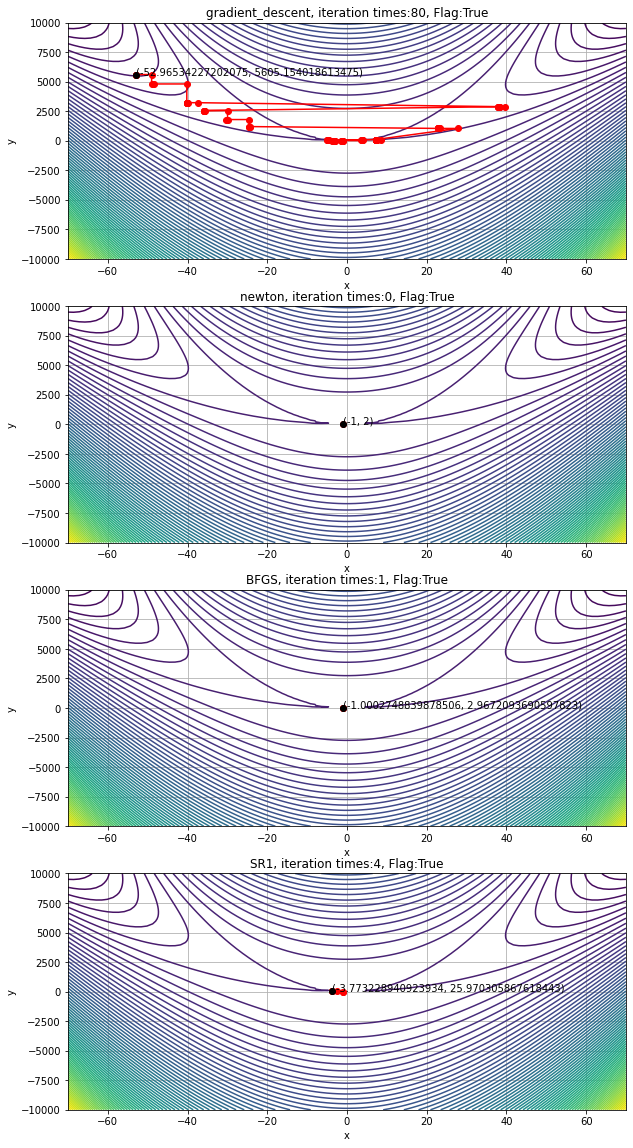

In [8]:
plot_all(fRosenbrock,x4,a=70,b=10000,l=100, max_iter=10000)

For gradient descent, the iteration is 1 the current location is [-2. -4.] and the current objective value is -26.0
For gradient descent, the iteration is 2 the current location is [-4.9982238 -9.0017762] and the current objective value is -60.00355239786856
For gradient descent, the iteration is 3 the current location is [ -7.9964476 -14.0035524] and the current objective value is -94.00710479573712
For gradient descent, the iteration is 4 the current location is [-10.9946714 -19.0053286] and the current objective value is -128.01065719360568
For gradient descent, the iteration is 5 the current location is [-13.97868561 -23.987535  ] and the current objective value is -161.87373185084988
For gradient descent, the iteration is 6 the current location is [-16.99111901 -28.99821116] and the current objective value is -195.9644128113879
For gradient descent, the iteration is 7 the current location is [-19.98044285 -34.00888732] and the current objective value is -229.98576512455514
For gra

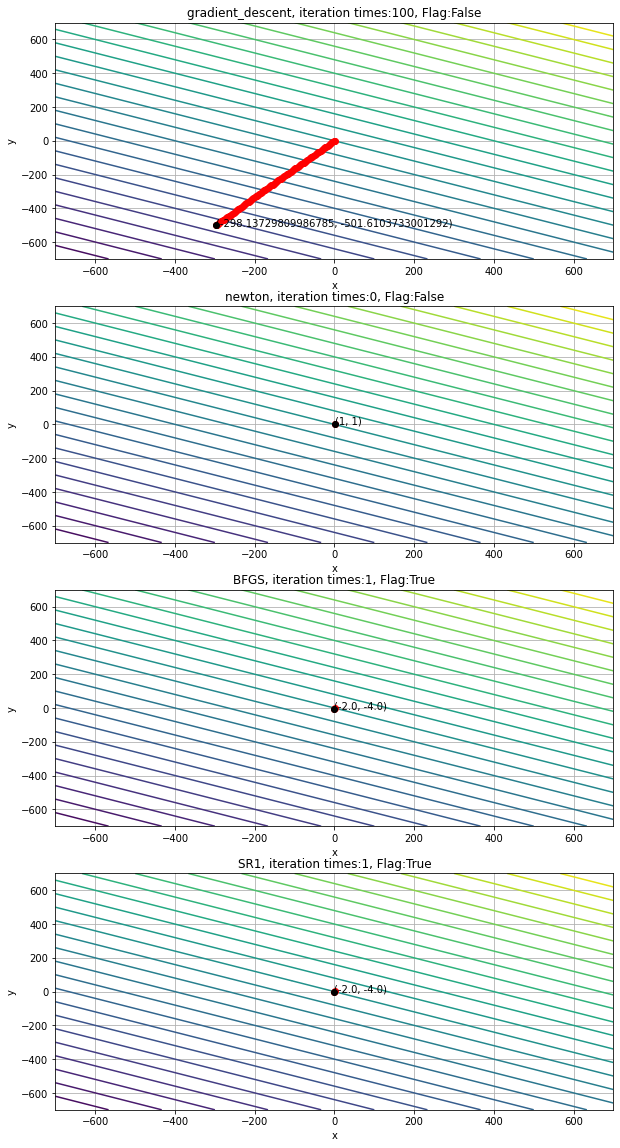

In [9]:
plot_all(f5,x,a=700,b=700,l=30)

For gradient descent, the iteration is 1 the current location is [0.85134292 0.55319132] and the current objective value is 11.93363340802091
For gradient descent, the iteration is 2 the current location is [0.72264376 0.18169639] and the current objective value is 4.734606406734292
For gradient descent, the iteration is 3 the current location is [0.61414136 0.0014974 ] and the current objective value is 3.834050195226797
For gradient descent, the iteration is 4 the current location is [-0.13430931 -0.01026055] and the current objective value is 2.6178884712316064
For gradient descent, the iteration is 5 the current location is [-0.277965    0.02804008] and the current objective value is 2.5701443380668145
For gradient descent, the iteration is 6 the current location is [-0.29345302 -0.0017146 ] and the current objective value is 2.5628962615248323
For gradient descent, the iteration is 7 the current location is [-0.33798286  0.00527032] and the current objective value is 2.55952246377

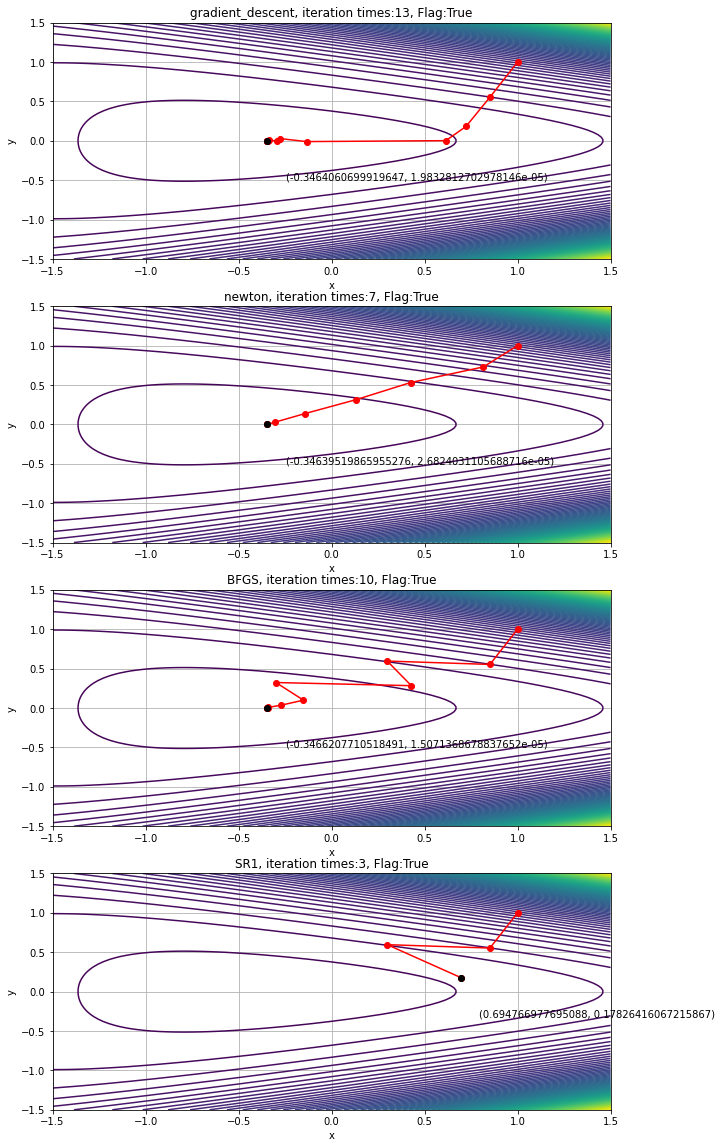

In [10]:
plot_all(f6,x,a=1.5,b=1.5,l=100)